In [11]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths
project_root = Path(r'C:\Users\a7654\OneDrive\Ambiente de Trabalho\STUDY\projects\projects\mibel-intelligence')
sys.path.insert(0, str(project_root))

# Plotting setup
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Check if 2-year panel exists
PROCESSED_DIR = project_root / 'data' / 'processed'
panel_file = PROCESSED_DIR / "main_panel_2022-01-01_2023-12-31.parquet"

if not panel_file.exists():
    print("2-year panel not found. Building now...")
    print("This takes 5-10 minutes...\n")
    
    from src.data.build_panel import build_main_panel
    
    panel = build_main_panel(
        start_date='2022-01-01',
        end_date='2023-12-31',
        countries=['ES', 'PT']
    )
    
    print(f"✅ Panel built: {len(panel):,} rows")
else:
    print("Loading existing 2-year panel...")

# Load the panel
df = pd.read_parquet(panel_file)

print(f"✅ Loaded 2-year panel: {len(df):,} rows")
print(f"📅 Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"🌍 Countries: {sorted(df['country'].unique())}")
print(f"💰 Mean price: {df['price_eur_mwh'].mean():.2f} EUR/MWh")

# Create period splits
exception_start = pd.Timestamp('2022-06-15', tz='UTC')

pre_exception = df[~df['is_iberian_exception']].copy()
during_exception = df[df['is_iberian_exception']].copy()

print(f"\n📊 Period breakdown:")
print(f"   Pre-exception: {len(pre_exception):,} rows ({len(pre_exception)/len(df)*100:.1f}%)")
print(f"   During exception: {len(during_exception):,} rows ({len(during_exception)/len(df)*100:.1f}%)")

# Create country subsets
spain = df[df['country'] == 'ES'].sort_values('timestamp').copy()
portugal = df[df['country'] == 'PT'].sort_values('timestamp').copy()

spain_pre = spain[~spain['is_iberian_exception']].copy()
spain_during = spain[spain['is_iberian_exception']].copy()

portugal_pre = portugal[~portugal['is_iberian_exception']].copy()
portugal_during = portugal[portugal['is_iberian_exception']].copy()

print(f"\n✅ Data loaded and segmented")
print(f"   Spain pre: {len(spain_pre):,} rows")
print(f"   Spain during: {len(spain_during):,} rows")

Loading existing 2-year panel...
✅ Loaded 2-year panel: 35,040 rows
📅 Date range: 2022-01-01 00:00:00+00:00 to 2023-12-31 23:00:00+00:00
🌍 Countries: ['ES', 'PT']
💰 Mean price: 127.71 EUR/MWh

📊 Period breakdown:
   Pre-exception: 7,920 rows (22.6%)
   During exception: 27,120 rows (77.4%)

✅ Data loaded and segmented
   Spain pre: 3,960 rows
   Spain during: 13,560 rows


In [3]:
from src.utils.db_utils import execute_query

result = execute_query("""
    SELECT 
        COUNT(*) as rows,
        COUNT(DISTINCT country) as countries,
        MIN(timestamp) as start,
        MAX(timestamp) as end
    FROM prices_day_ahead
""")

print("Database status:")
print(result)

if result['rows'].iloc[0] > 0:
    print(f"\n✅ SUCCESS! Database has {result['rows'].iloc[0]:,} rows")
else:
    print("\n❌ Still empty - run fix_midnight_hour.py again")

Database status:
    rows  countries      start                 end
0  35032          2 2022-01-01 2023-12-31 23:00:00

✅ SUCCESS! Database has 35,032 rows


C:\Users\a7654\AppData\Local\Temp\ipykernel_40532\285055517.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = spain.set_index('timestamp').resample('M')['price_eur_mwh'].mean()


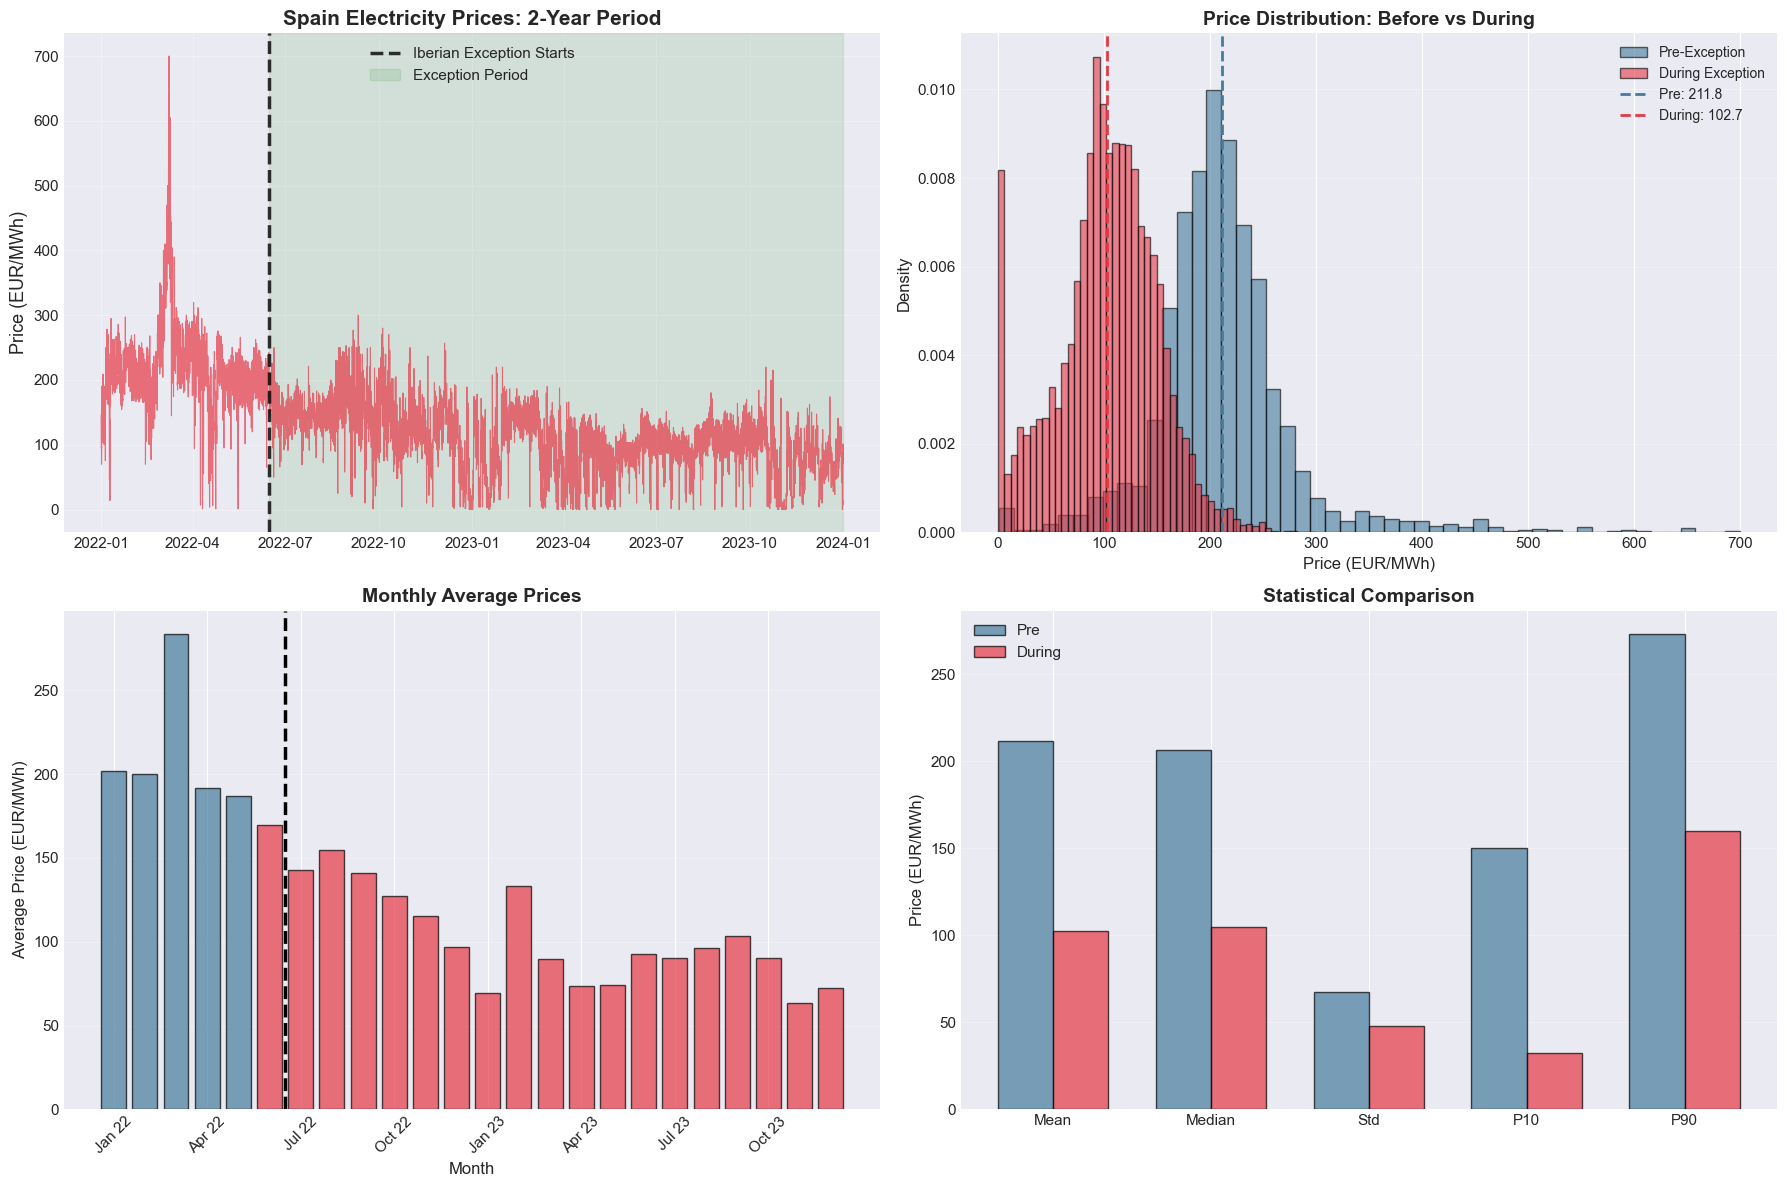

 IBERIAN EXCEPTION IMPACT - SPAIN

📊 Pre-Exception (2022-01-01 to 2022-06-14):
   Mean: 211.80 EUR/MWh
   Median: 206.66 EUR/MWh
   Std: 67.45 EUR/MWh
   Range: 1.03 - 700.00

📊 During Exception (2022-06-15 to 2023-12-31):
   Mean: 102.66 EUR/MWh
   Median: 105.00 EUR/MWh
   Std: 47.84 EUR/MWh
   Range: 0.00 - 300.00

💰 Impact:
   Change: -109.14 EUR/MWh (-51.5%)
   ✅ Prices DECREASED by 109.14 EUR/MWh
   💰 Est. savings: 1.5 million EUR·h


In [13]:
# Cell 2: Iberian Exception Impact Analysis

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# 1. Full time series with intervention
ax1.plot(spain['timestamp'], spain['price_eur_mwh'], 
         linewidth=0.8, alpha=0.7, color='#E63946')
ax1.axvline(exception_start, color='black', linestyle='--', linewidth=2.5, 
           label='Iberian Exception Starts', alpha=0.8)
ax1.axvspan(exception_start, spain['timestamp'].max(), 
           alpha=0.1, color='green', label='Exception Period')
ax1.set_ylabel('Price (EUR/MWh)', fontsize=13)
ax1.set_title('Spain Electricity Prices: 2-Year Period', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Distribution comparison
ax2.hist(spain_pre['price_eur_mwh'].dropna(), bins=50, alpha=0.6, 
         color='#457B9D', label='Pre-Exception', density=True, edgecolor='black')
ax2.hist(spain_during['price_eur_mwh'].dropna(), bins=50, alpha=0.6, 
         color='#E63946', label='During Exception', density=True, edgecolor='black')
ax2.axvline(spain_pre['price_eur_mwh'].mean(), color='#457B9D', 
           linestyle='--', linewidth=2, label=f'Pre: {spain_pre["price_eur_mwh"].mean():.1f}')
ax2.axvline(spain_during['price_eur_mwh'].mean(), color='#E63946', 
           linestyle='--', linewidth=2, label=f'During: {spain_during["price_eur_mwh"].mean():.1f}')
ax2.set_xlabel('Price (EUR/MWh)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Price Distribution: Before vs During', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# 3. Monthly average prices
monthly = spain.set_index('timestamp').resample('M')['price_eur_mwh'].mean()
colors = ['#457B9D' if m < exception_start else '#E63946' for m in monthly.index]
ax3.bar(range(len(monthly)), monthly.values, color=colors, alpha=0.7, edgecolor='black')
ax3.axvline(5.5, color='black', linestyle='--', linewidth=2.5)
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Average Price (EUR/MWh)', fontsize=12)
ax3.set_title('Monthly Average Prices', fontsize=14, fontweight='bold')
ax3.set_xticks(range(0, len(monthly), 3))
ax3.set_xticklabels([monthly.index[i].strftime('%b %y') for i in range(0, len(monthly), 3)], rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Statistical comparison
stats_labels = ['Mean', 'Median', 'Std', 'P10', 'P90']
pre_stats = [
    spain_pre['price_eur_mwh'].mean(),
    spain_pre['price_eur_mwh'].median(),
    spain_pre['price_eur_mwh'].std(),
    spain_pre['price_eur_mwh'].quantile(0.1),
    spain_pre['price_eur_mwh'].quantile(0.9)
]
during_stats = [
    spain_during['price_eur_mwh'].mean(),
    spain_during['price_eur_mwh'].median(),
    spain_during['price_eur_mwh'].std(),
    spain_during['price_eur_mwh'].quantile(0.1),
    spain_during['price_eur_mwh'].quantile(0.9)
]

x = np.arange(len(stats_labels))
width = 0.35
ax4.bar(x - width/2, pre_stats, width, label='Pre', color='#457B9D', alpha=0.7, edgecolor='black')
ax4.bar(x + width/2, during_stats, width, label='During', color='#E63946', alpha=0.7, edgecolor='black')
ax4.set_ylabel('Price (EUR/MWh)', fontsize=12)
ax4.set_title('Statistical Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(stats_labels)
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print statistics
print("="*80)
print(" IBERIAN EXCEPTION IMPACT - SPAIN")
print("="*80)

print(f"\n📊 Pre-Exception ({spain_pre['timestamp'].min().date()} to {spain_pre['timestamp'].max().date()}):")
print(f"   Mean: {spain_pre['price_eur_mwh'].mean():.2f} EUR/MWh")
print(f"   Median: {spain_pre['price_eur_mwh'].median():.2f} EUR/MWh")
print(f"   Std: {spain_pre['price_eur_mwh'].std():.2f} EUR/MWh")
print(f"   Range: {spain_pre['price_eur_mwh'].min():.2f} - {spain_pre['price_eur_mwh'].max():.2f}")

print(f"\n📊 During Exception ({spain_during['timestamp'].min().date()} to {spain_during['timestamp'].max().date()}):")
print(f"   Mean: {spain_during['price_eur_mwh'].mean():.2f} EUR/MWh")
print(f"   Median: {spain_during['price_eur_mwh'].median():.2f} EUR/MWh")
print(f"   Std: {spain_during['price_eur_mwh'].std():.2f} EUR/MWh")
print(f"   Range: {spain_during['price_eur_mwh'].min():.2f} - {spain_during['price_eur_mwh'].max():.2f}")

mean_diff = spain_during['price_eur_mwh'].mean() - spain_pre['price_eur_mwh'].mean()
pct_change = (mean_diff / spain_pre['price_eur_mwh'].mean()) * 100

print(f"\n💰 Impact:")
print(f"   Change: {mean_diff:+.2f} EUR/MWh ({pct_change:+.1f}%)")

if mean_diff < 0:
    print(f"   ✅ Prices DECREASED by {abs(mean_diff):.2f} EUR/MWh")
    savings = abs(mean_diff) * len(spain_during)
    print(f"   💰 Est. savings: {savings/1e6:.1f} million EUR·h")
else:
    print(f"   ⚠️ Prices INCREASED by {mean_diff:.2f} EUR/MWh")

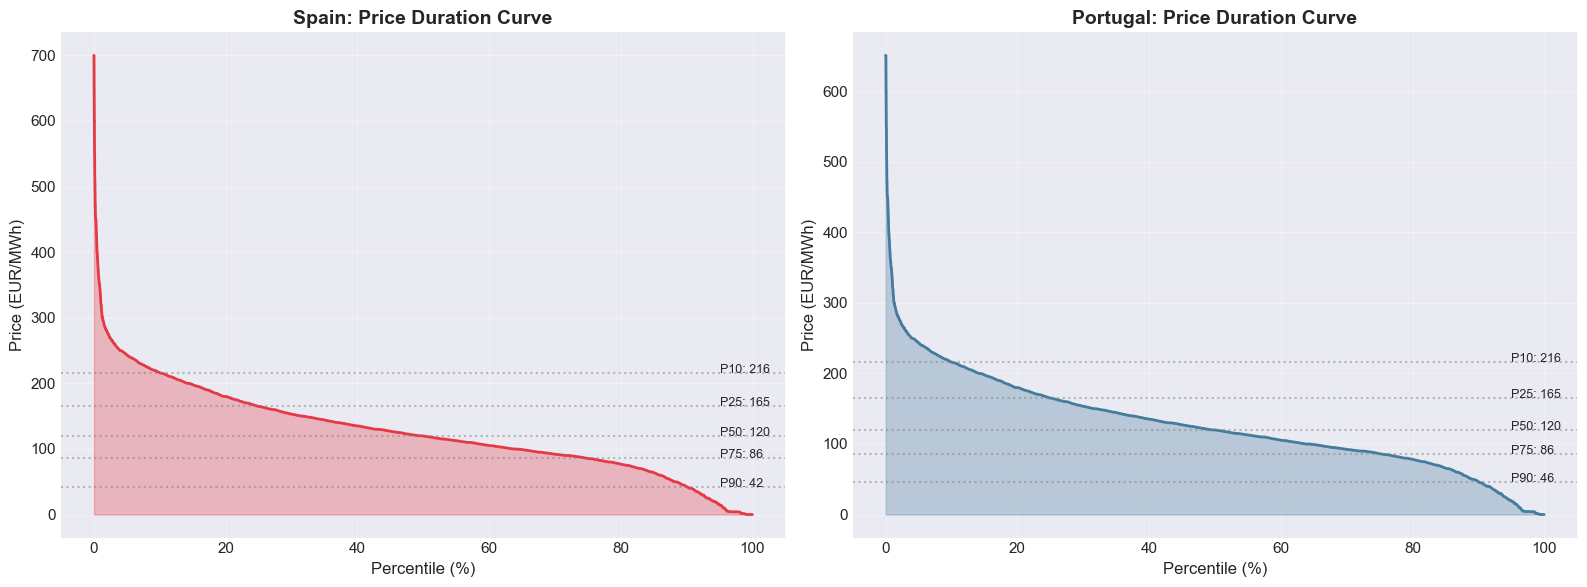

In [14]:
# Cell 3: Price Duration Curves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Spain
spain_sorted = spain['price_eur_mwh'].sort_values(ascending=False).reset_index(drop=True)
spain_sorted.index = (spain_sorted.index / len(spain_sorted)) * 100

ax1.plot(spain_sorted.index, spain_sorted.values, linewidth=2, color='#E63946')
ax1.fill_between(spain_sorted.index, spain_sorted.values, alpha=0.3, color='#E63946')
ax1.set_xlabel('Percentile (%)', fontsize=12)
ax1.set_ylabel('Price (EUR/MWh)', fontsize=12)
ax1.set_title('Spain: Price Duration Curve', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add percentile markers
for p in [10, 25, 50, 75, 90]:
    price = spain_sorted.iloc[int(p * len(spain_sorted) / 100)]
    ax1.axhline(price, color='gray', linestyle=':', alpha=0.5)
    ax1.text(95, price, f'P{p}: {price:.0f}', fontsize=9)

# Portugal
portugal_sorted = portugal['price_eur_mwh'].sort_values(ascending=False).reset_index(drop=True)
portugal_sorted.index = (portugal_sorted.index / len(portugal_sorted)) * 100

ax2.plot(portugal_sorted.index, portugal_sorted.values, linewidth=2, color='#457B9D')
ax2.fill_between(portugal_sorted.index, portugal_sorted.values, alpha=0.3, color='#457B9D')
ax2.set_xlabel('Percentile (%)', fontsize=12)
ax2.set_ylabel('Price (EUR/MWh)', fontsize=12)
ax2.set_title('Portugal: Price Duration Curve', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

for p in [10, 25, 50, 75, 90]:
    price = portugal_sorted.iloc[int(p * len(portugal_sorted) / 100)]
    ax2.axhline(price, color='gray', linestyle=':', alpha=0.5)
    ax2.text(95, price, f'P{p}: {price:.0f}', fontsize=9)

plt.tight_layout()
plt.show()

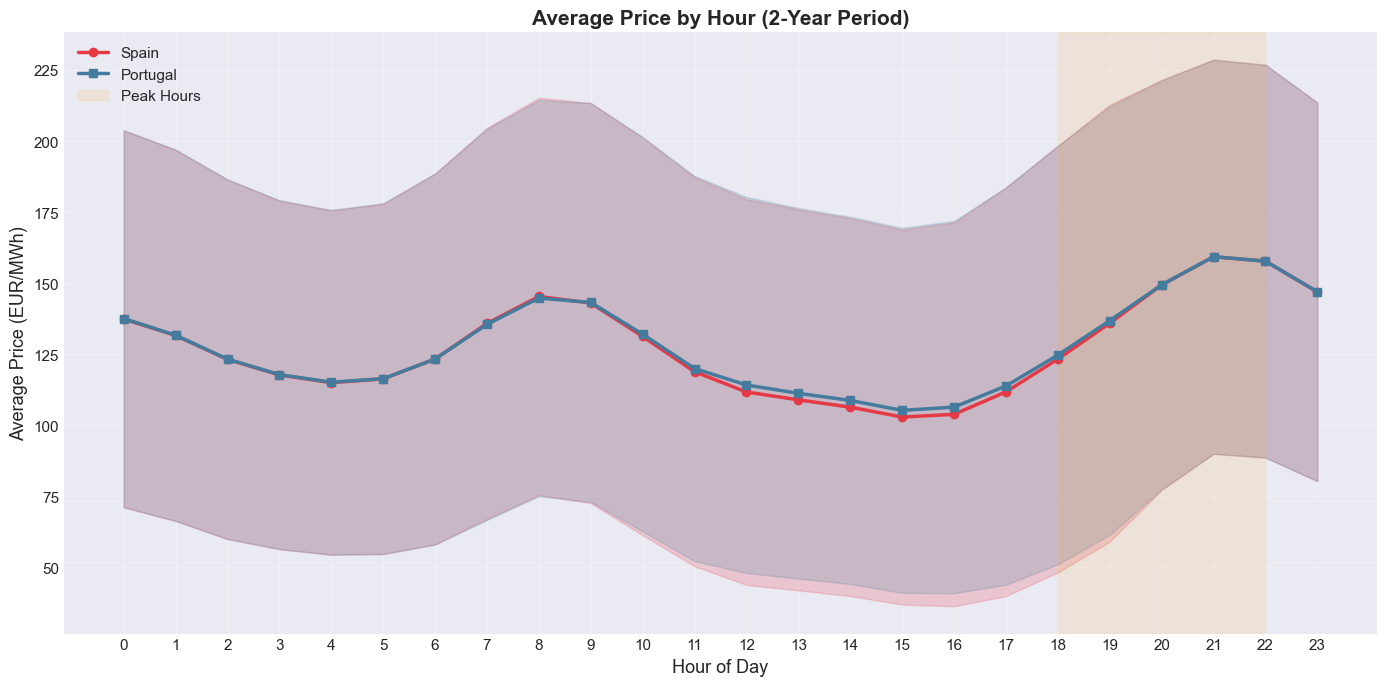

⚡ Peak Hours:
   Spain peak: 21:00 - 159.26 EUR/MWh
   Spain lowest: 15:00 - 102.84 EUR/MWh
   Peak-to-trough: 56.42 EUR/MWh


In [15]:
# Cell 4: Hourly Price Patterns

hourly_spain = spain.groupby('hour')['price_eur_mwh'].agg(['mean', 'std']).reset_index()
hourly_portugal = portugal.groupby('hour')['price_eur_mwh'].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(hourly_spain['hour'], hourly_spain['mean'], 
        marker='o', linewidth=2.5, markersize=6, label='Spain', color='#E63946')
ax.fill_between(hourly_spain['hour'], 
                hourly_spain['mean'] - hourly_spain['std'],
                hourly_spain['mean'] + hourly_spain['std'],
                alpha=0.2, color='#E63946')

ax.plot(hourly_portugal['hour'], hourly_portugal['mean'], 
        marker='s', linewidth=2.5, markersize=6, label='Portugal', color='#457B9D')
ax.fill_between(hourly_portugal['hour'], 
                hourly_portugal['mean'] - hourly_portugal['std'],
                hourly_portugal['mean'] + hourly_portugal['std'],
                alpha=0.2, color='#457B9D')

ax.axvspan(18, 22, alpha=0.1, color='orange', label='Peak Hours')

ax.set_xlabel('Hour of Day', fontsize=13)
ax.set_ylabel('Average Price (EUR/MWh)', fontsize=13)
ax.set_title('Average Price by Hour (2-Year Period)', fontsize=15, fontweight='bold')
ax.set_xticks(range(0, 24))
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find peak hours
spain_peak = hourly_spain.loc[hourly_spain['mean'].idxmax()]
spain_low = hourly_spain.loc[hourly_spain['mean'].idxmin()]

print("⚡ Peak Hours:")
print(f"   Spain peak: {int(spain_peak['hour'])}:00 - {spain_peak['mean']:.2f} EUR/MWh")
print(f"   Spain lowest: {int(spain_low['hour'])}:00 - {spain_low['mean']:.2f} EUR/MWh")
print(f"   Peak-to-trough: {spain_peak['mean'] - spain_low['mean']:.2f} EUR/MWh")

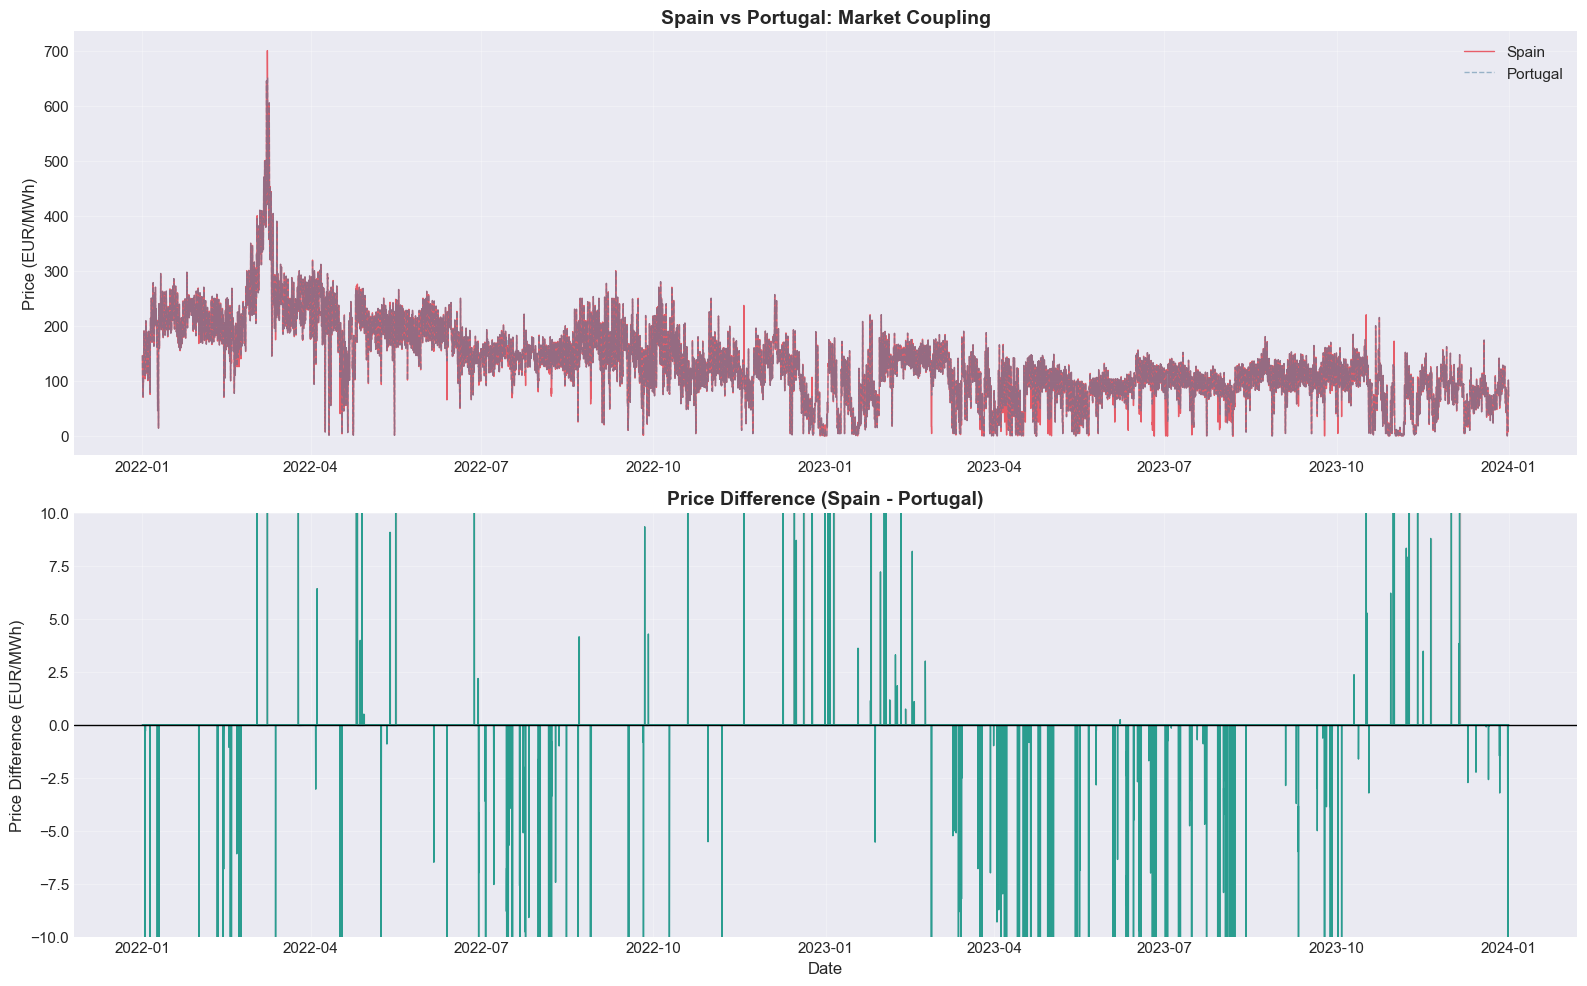

🔗 Market Coupling Analysis:
   Correlation: 0.995285
   Avg difference: -0.771 EUR/MWh
   Max difference: 122.39 EUR/MWh
   Identical prices: 16802 / 17520 (95.9%)

✅ Markets are HIGHLY COUPLED (>95% identical prices)


In [16]:
# Cell 5: Spain vs Portugal Market Coupling

spain_data = spain[['timestamp', 'price_eur_mwh']].copy()
spain_data = spain_data.rename(columns={'price_eur_mwh': 'price_spain'})

portugal_data = portugal[['timestamp', 'price_eur_mwh']].copy()
portugal_data = portugal_data.rename(columns={'price_eur_mwh': 'price_portugal'})

comparison = spain_data.merge(portugal_data, on='timestamp', how='inner')
comparison['price_diff'] = comparison['price_spain'] - comparison['price_portugal']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Plot prices
ax1.plot(comparison['timestamp'], comparison['price_spain'], 
         linewidth=1, alpha=0.8, label='Spain', color='#E63946')
ax1.plot(comparison['timestamp'], comparison['price_portugal'], 
         linewidth=1, alpha=0.5, label='Portugal', color='#457B9D', linestyle='--')
ax1.set_ylabel('Price (EUR/MWh)', fontsize=12)
ax1.set_title('Spain vs Portugal: Market Coupling', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot difference
ax2.plot(comparison['timestamp'], comparison['price_diff'], linewidth=1, color='#2A9D8F')
ax2.axhline(0, color='black', linestyle='-', linewidth=1)
ax2.fill_between(comparison['timestamp'], comparison['price_diff'], 0, 
                 where=(comparison['price_diff'] > 0), alpha=0.3, color='#E63946')
ax2.fill_between(comparison['timestamp'], comparison['price_diff'], 0, 
                 where=(comparison['price_diff'] <= 0), alpha=0.3, color='#457B9D')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Price Difference (EUR/MWh)', fontsize=12)
ax2.set_title('Price Difference (Spain - Portugal)', fontsize=14, fontweight='bold')
ax2.set_ylim([-10, 10])
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
corr = comparison['price_spain'].corr(comparison['price_portugal'])
identical = (comparison['price_diff'].abs() < 0.01).sum()

print("🔗 Market Coupling Analysis:")
print(f"   Correlation: {corr:.6f}")
print(f"   Avg difference: {comparison['price_diff'].mean():.3f} EUR/MWh")
print(f"   Max difference: {comparison['price_diff'].abs().max():.2f} EUR/MWh")
print(f"   Identical prices: {identical} / {len(comparison)} ({identical/len(comparison)*100:.1f}%)")

if identical / len(comparison) > 0.95:
    print("\n✅ Markets are HIGHLY COUPLED (>95% identical prices)")